# **GRU Exercise**

## Import libraries

In [21]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## load the dataset
### Dataset path : 5- Time series forecasting/2-2- Time Series Forecasting (LSTM and GRU)/ LAB/Dataset/traffic.csv


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/T5 Bootcamp/Dataset/week_5/Copy of traffic.csv')
data

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


## Data Exploration



In [4]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

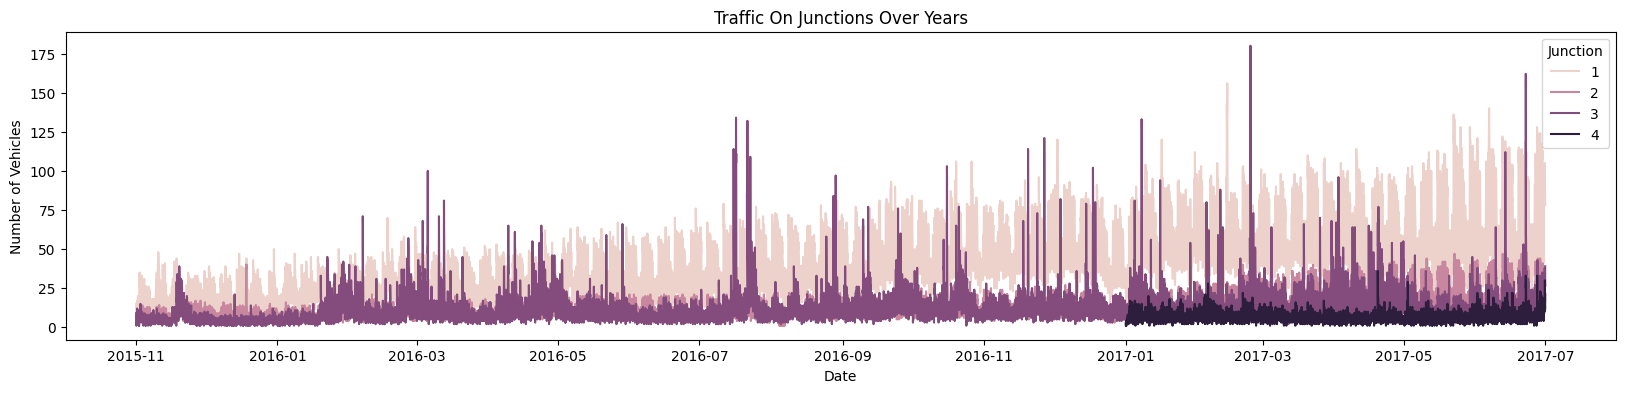

In [6]:
plt.figure(figsize=(20,4))
Time_series=sns.lineplot(x=data['DateTime'],y="Vehicles",data=data, hue="Junction")
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

# Feature Engineering

In [10]:
#Exploring more features
data["Year"]= data['DateTime'].dt.year
data["Month"]= data['DateTime'].dt.month
data["Date_no"]= data['DateTime'].dt.day
data["Hour"]= data['DateTime'].dt.hour

data.head(10)

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday
5,2015-11-01 05:00:00,1,6,2015,11,1,5,Sunday
6,2015-11-01 06:00:00,1,9,2015,11,1,6,Sunday
7,2015-11-01 07:00:00,1,8,2015,11,1,7,Sunday
8,2015-11-01 08:00:00,1,11,2015,11,1,8,Sunday
9,2015-11-01 09:00:00,1,12,2015,11,1,9,Sunday


In [25]:
# We will use the 'Close' column as our target variable
data = data[['Vehicles']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for the GRU model
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60  # Using 60 days of data to predict the next day

# Create the sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape the data for the GRU model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Exploratory Data Analysis


Text(0.5, 0, 'Date')

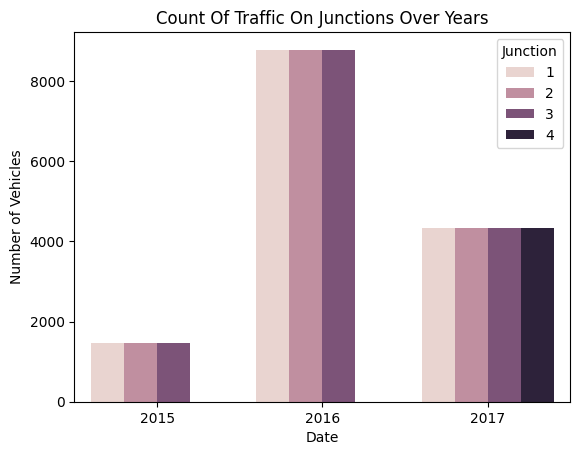

In [ ]:
count = sns.countplot(data=data, x =data["Year"], hue="Junction")
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

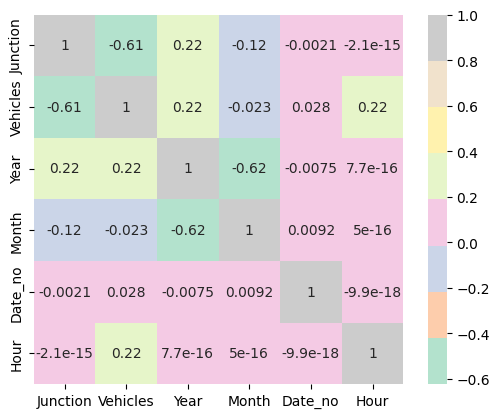

In [ ]:
data_num = data[['Junction','Vehicles',	'Year','Month','Date_no','Hour']]
corrmat = data_num.corr()
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

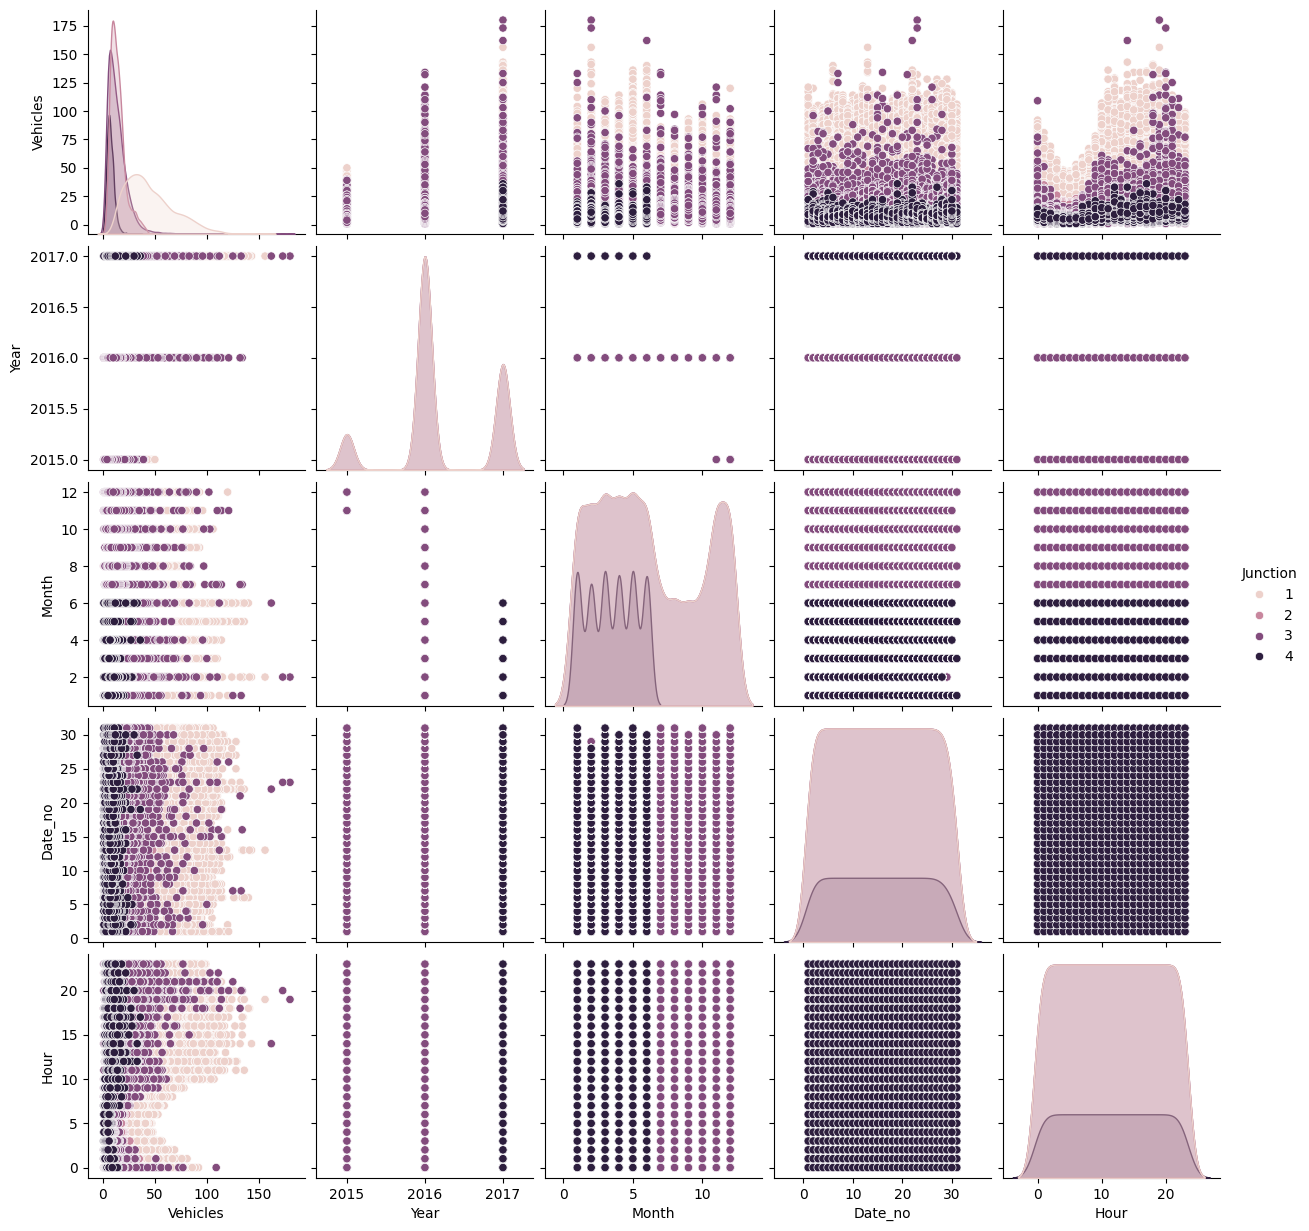

In [ ]:
sns.pairplot(data=data, hue= "Junction")

## split into train and test sets

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[['Vehicles']] = scaler.fit_transform(data[['Vehicles']])
data[['Junction']] = scaler.fit_transform(data[['Junction']])

In [19]:
X = data.drop('Vehicles',axis=1)
y = data.Vehicles

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Model Building & Fitting The Model



In [26]:
# Build the GRU model
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 123s 82ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 2/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 141s 81ms/step - loss: 6.9133e-04 - val_loss: 8.1988e-04
Epoch 3/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 141s 80ms/step - loss: 6.3531e-04 - val_loss: 8.7984e-04
Epoch 4/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 96s 80ms/step - loss: 6.4742e-04 - val_loss: 7.9870e-04
Epoch 5/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 152s 89ms/step - loss: 6.2507e-04 - val_loss: 9.0559e-04
Epoch 6/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - loss: 5.5727e-04 - val_loss: 8.0062e-04
Epoch 7/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 139s 83ms/step - loss: 5.4531e-04 - val_loss: 7.8752e-04
Epoch 8/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - loss: 5.6266e-04 - val_loss: 7.4882e-04
Epoch 9/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 141s 80ms/step - loss: 5.3287e-04 - val_loss: 7.7337e-04
Epoch 10/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 144s 81ms/step - loss: 5.1449e-04 - val_loss: 8.0432e-04


## Make preductuion and evaluatuin matrix.

In [27]:
# Make predictions
y_pred = model.predict(X_test)

301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


## Visualize the result

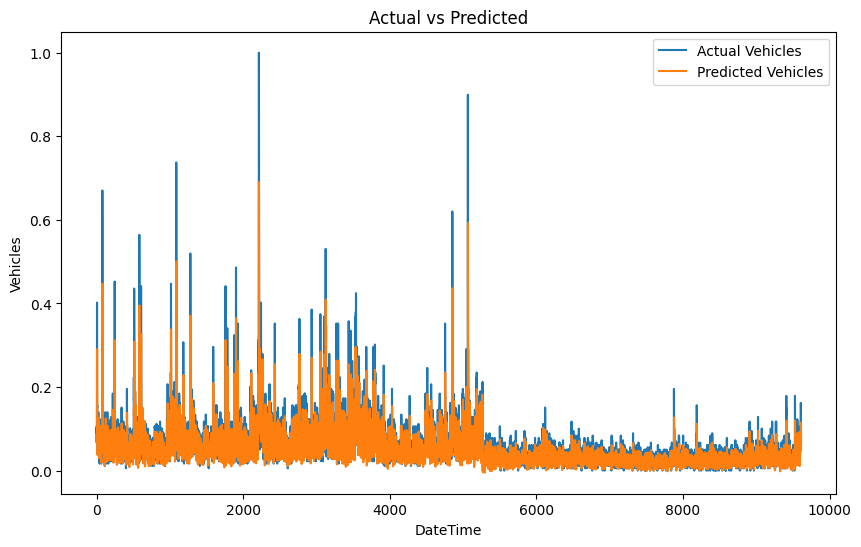

In [28]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Vehicles')
plt.plot(y_pred, label='Predicted Vehicles')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# **Well done** :)